In [ ]:
import numpy as np
import xgboost  
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

# Применение алгоритмов регресии для прогнозирования концентрации тяжелых металлов в воздухе


## Подготовка данных

### Импорт данных из MongoDb

In [ ]:
uri = open(".mongodb_token").read()

client = pymongo.MongoClient(uri)
db = client['heavymetals']
collection = db['heavymetals'] 

In [ ]:
df_bands = pd.DataFrame(list(db.metals_bands.find()))
df_metals = pd.DataFrame(list(db.metals_info.find()))
met_concent = df_metals.loc[:, df_metals.columns != 'status'].values[:, 6:]
bands = df_bands.loc[:,:].values[:, 1:9]

x = bands
y = met_concent
y = y.squeeze()
y_mean = y.mean()
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.01)

In [ ]:
def  print_info(y_pred,ytest,y_mean):
  df = pd.DataFrame({'Actual': ytest.flatten(), 'Predicted': y_pred.flatten()})
  df.head()

  df1 = df.head(25)
  df1.plot(kind='bar',figsize=(16,10))
  plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
  plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  plt.show()


  x_ax = range(len(ytest))
  rmse = np.sqrt(metrics.mean_squared_error(ytest, y_pred))
  
  mse = metrics.mean_squared_error(ytest, y_pred)
  msePerc = (mse/y_mean)*100
  rmsePerc = (rmse/y_mean)*100
  print('Mean Absolute Error:', metrics.mean_absolute_error(ytest, y_pred))  
  print('Mean Squared Error:', metrics.mean_squared_error(ytest, y_pred))  
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, y_pred)))
  print(f'Процент от среднего значения(RMSE): {rmsePerc}%')
  print(f'Процент от среднего значения(MSE): {msePerc}%')

  plt.scatter(x_ax, ytest, s=5, color="blue", label="original")
  plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
  plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
  plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  plt.legend()
  plt.show()

## Random Forest

In [ ]:
xtrain.shape

(144, 8)

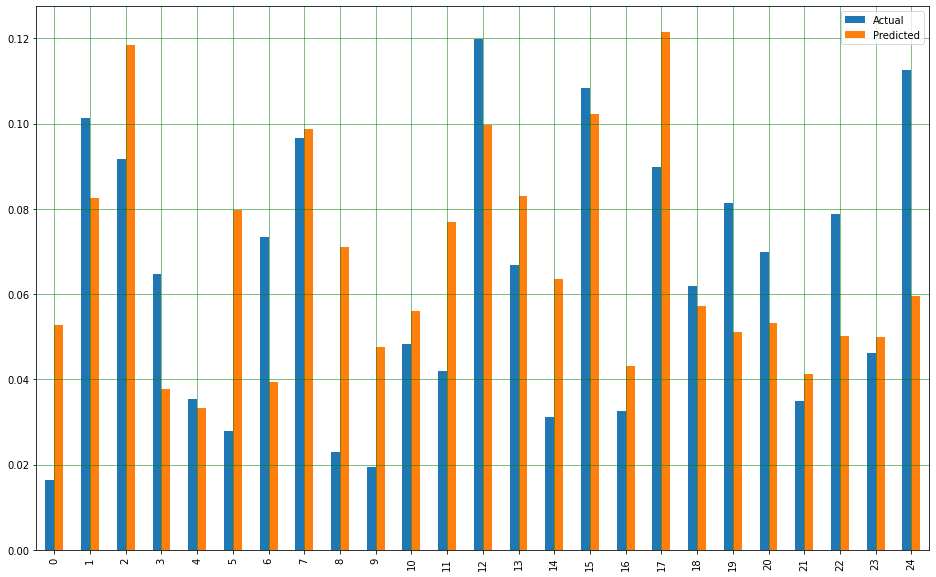

Mean Absolute Error: 0.024143102767052768
Mean Squared Error: 0.0008988367679249213
Root Mean Squared Error: 0.02998060653030424
Процент от среднего значения(RMSE): 48.05052360235776%
Процент от среднего значения(MSE): 1.440583841697385%


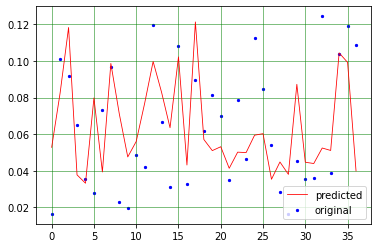

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(xtrain, ytrain)
y_pred = model.predict(xtest)

print_info(y_pred,ytest,y_mean)

## Линейная регрессия sklearn

0.060409240799377956
[-0.00836465 -0.11188036  0.06571829  0.00918948  0.05776622  0.14047529
 -0.0996065  -0.06727619]


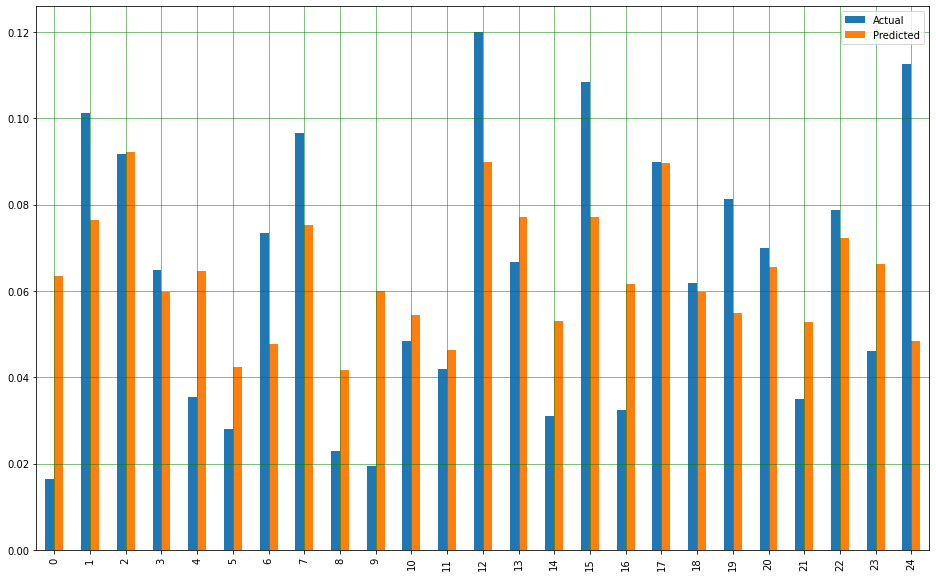

Mean Absolute Error: 0.024109797917591883
Mean Squared Error: 0.0008503117113012031
Root Mean Squared Error: 0.029160104788926996
Процент от среднего значения(RMSE): 46.73548888983545%
Процент от среднего значения(MSE): 1.3628117533893351%


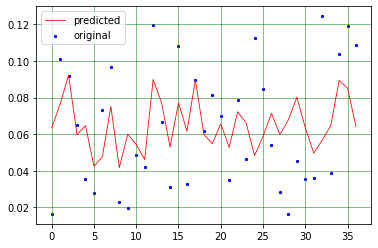

In [ ]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()  
regressor.fit(xtrain, ytrain) #training the algorithm

print(regressor.intercept_)#For retrieving the slope:
print(regressor.coef_)

y_pred = regressor.predict(xtest)

print_info(y_pred,ytest,y_mean)

##  XGBoost regressor

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)
Training score:  0.8250579225626109
Mean cross-validation score: 0.22
K-fold CV average score: 0.20


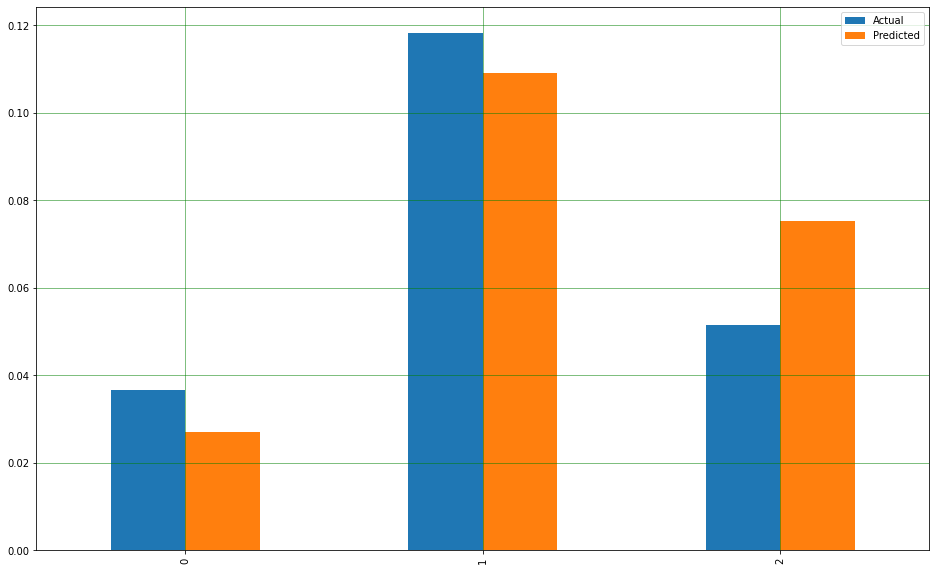

Mean Absolute Error: 0.014170838085810345
Mean Squared Error: 0.00024682332017529314
Root Mean Squared Error: 0.015710611705955092
Процент от среднего значения(RMSE): 19.42116075752829%
Процент от среднего значения(MSE): 0.3051183155404596%


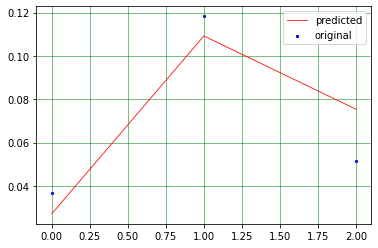

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

xgbr = xgb.XGBRegressor(verbosity=0)
print(xgbr)

xgbr.fit(xtrain, ytrain)

score = xgbr.score(xtrain, ytrain)   
print("Training score: ", score) 

# - cross validataion 
scores = cross_val_score(xgbr, xtrain, ytrain, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=4, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, xtrain, ytrain, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
 
y_pred = xgbr.predict(xtest)

print_info(y_pred,ytest,y_mean)

## Неросеть №1

In [ ]:
input_shape= xtrain.shape[1]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(xtrain.shape[1],)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
history = model.fit(xtrain, ytrain, epochs=100, batch_size=1, verbose=0)

In [ ]:
mse, mae = model.evaluate(xtest, ytest, verbose=1)
print("Средняя абсолютная ошибка:", mae)
print("Средняя квадратичная ошибка:", mse)

2/2 [==============================] - 0s 5ms/step - loss: 0.0015 - mae: 0.0324
Средняя абсолютная ошибка: 0.032436907291412354
Средняя квадратичная ошибка: 0.0015215802704915404


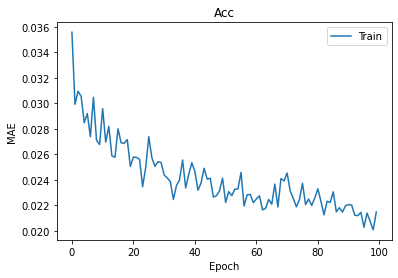

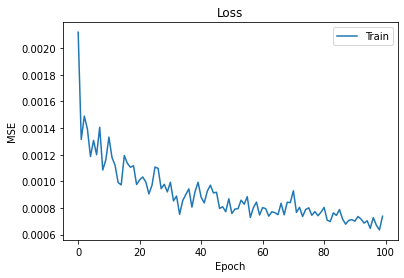

In [ ]:
plt.plot(history.history['mae'])

plt.title('Acc')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])

plt.title('Loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

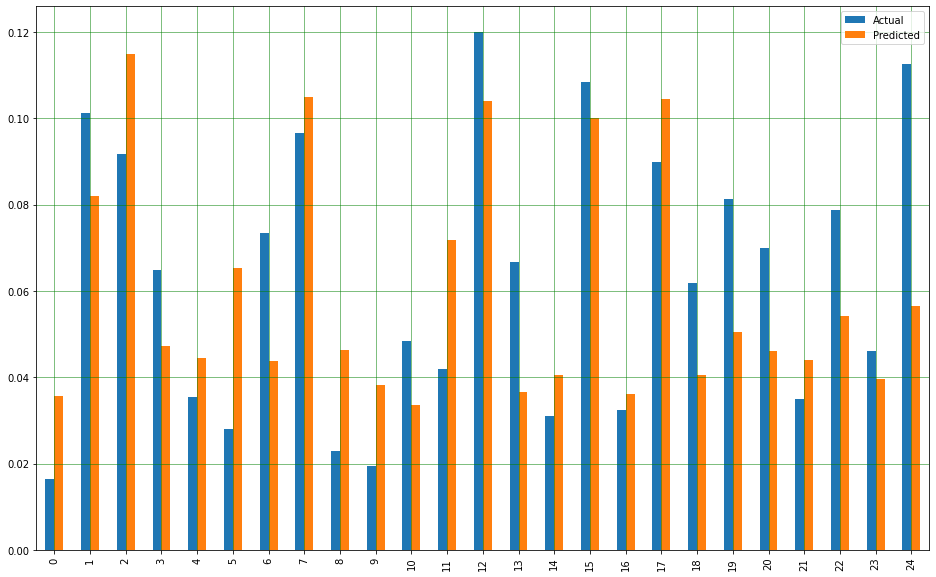

Mean Absolute Error: 0.022042984173910037
Mean Squared Error: 0.000778078824147446
Root Mean Squared Error: 0.02789406431747525
Процент от среднего значения(RMSE): 44.70638025610779%
Процент от среднего значения(MSE): 1.2470426462653763%


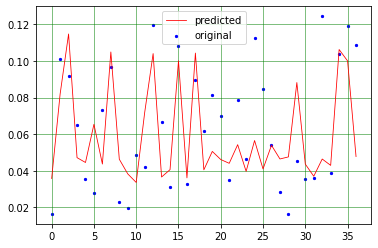

In [ ]:
y_pred  = model.predict(xtest)
print_info(y_pred,ytest,y_mean)

## Регрессия ElasticNet

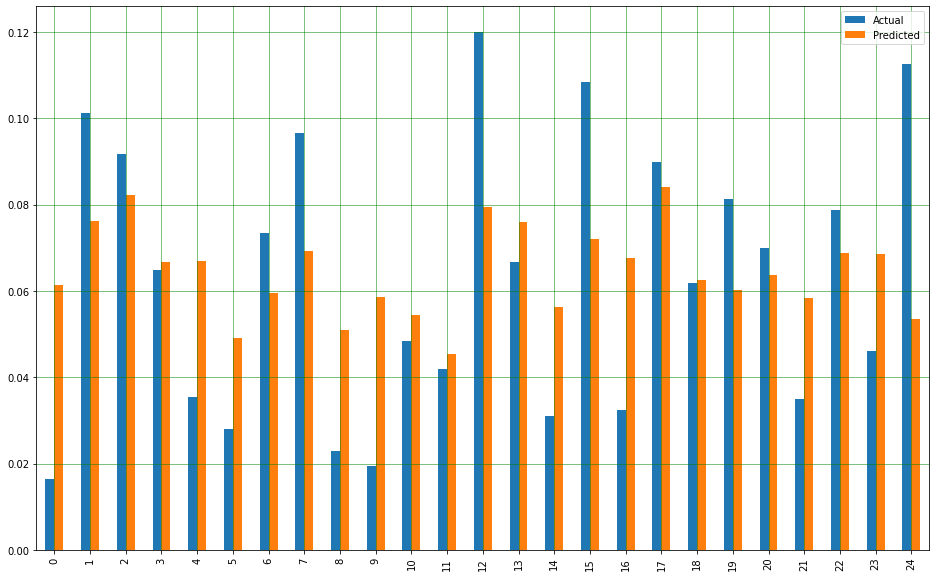

Mean Absolute Error: 0.02562390964822247
Mean Squared Error: 0.0009028181697496109
Root Mean Squared Error: 0.03004693278438934
Процент от среднего значения(RMSE): 48.15682602936672%
Процент от среднего значения(MSE): 1.4469649148139125%


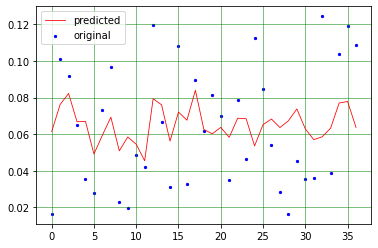

In [ ]:
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV()
model.fit(xtrain, ytrain)

y_pred = model.predict(xtest)

print_info(y_pred,ytest,y_mean)

## Гребневая регрессия (ридж-регрессия)

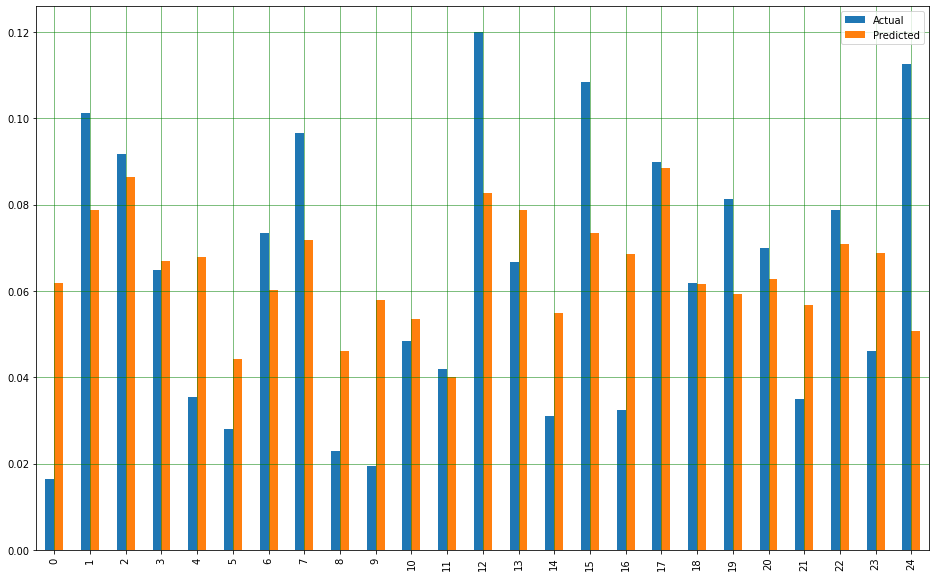

Mean Absolute Error: 0.024901523051840457
Mean Squared Error: 0.0008867033866497874
Root Mean Squared Error: 0.029777565156503098
Процент от среднего значения(RMSE): 47.72510509175406%
Процент от среднего значения(MSE): 1.4211374264706642%


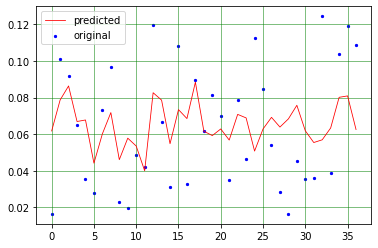

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn import linear_model
#clf = linear_model.Ridge
model = linear_model.Ridge()

model.fit(xtrain, ytrain)
y_pred = model.predict(xtest)
print_info(y_pred,ytest,y_mean)


## Регрессия LASSO
применяется при сильной корреляции признаков друг с другом

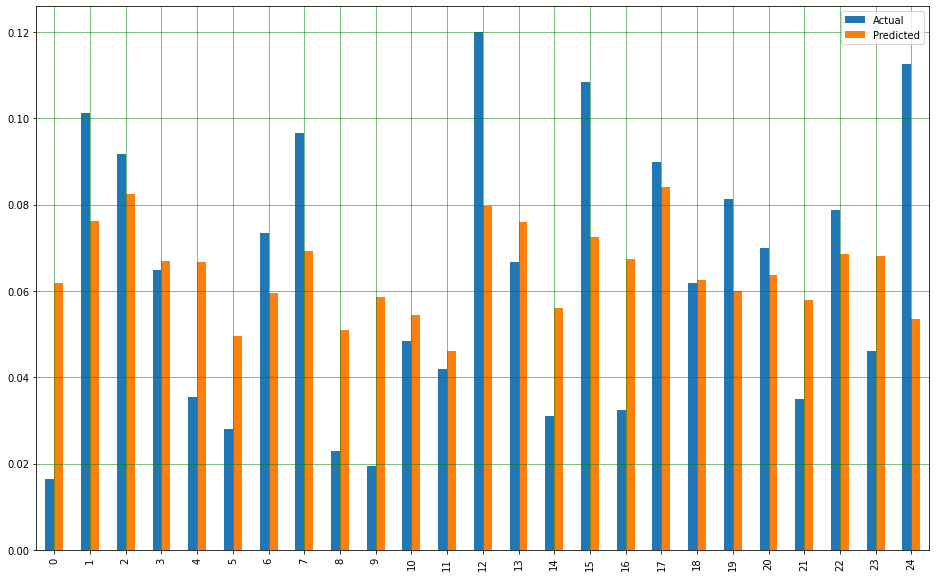

Mean Absolute Error: 0.02558608375253499
Mean Squared Error: 0.000900087024816035
Root Mean Squared Error: 0.030001450378540618
Процент от среднего значения(RMSE): 48.08393045890796%
Процент от среднего значения(MSE): 1.442587653668125%


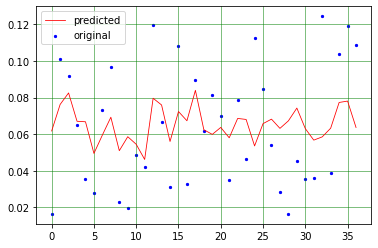

In [ ]:
from sklearn.linear_model import LassoCV
model = LassoCV()
model.fit(xtrain, ytrain)

y_pred = model.predict(xtest)

print_info(y_pred,ytest,y_mean)


### Вывод
Поскольку стандартные методы регрессии не предоставляют удовлетворяющего результата, необходимо производить оптимизацию параметров.